#Project question & success criteria:

Goal: Build a model to predict or cluster drug side-effects based on drug characteristics and user feedback.

Why this matters (AstraZeneca pharmacovigilance context): post-marketing surveillance needs fast signal detection for adverse events (AEs).

 We want:

Supervised prediction: given a drug’s characteristics + user text, estimate probability that each AE label occurs (multi-label).

Unsupervised clustering: group drugs by similar AE profiles to surface unexpected patterns (signals).

Success metrics: label-wise ROC-AUC and PR-AUC (class-imbalance robust), plus qualitative inspection of clusters/topics for clinical plausibility.

#Setup & imports (What/Why/How):

What: bring in pandas/numpy for data wrangling; scikit-learn for preprocessing, TF-IDF, pipelines, One-Vs-Rest logistic regression, and evaluation; matplotlib for plots.

Why: ensures we can create a reproducible end-to-end pipeline: raw data → features → model → metrics.

How it builds toward the conclusion: this imports the exact tools we’ll use to deliver both prediction (supervised) and clustering (unsupervised) answers to the project question.

In [2]:
# === Setup & Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

RANDOM_STATE = 42
plt.rcParams['figure.figsize'] = (9, 5)


#Load & harmonize raw data:

What: read the datasets (drugs, user reviews/ratings, side-effect labels); standardize column names, strip whitespace, normalize text, and align keys (e.g., medicine_name). Handle missing values.

Why: pharmacovigilance data is messy (duplicates, spelling, missing text). Harmonization avoids data leakage and inconsistent joins.

How it builds: creates one clean analytical table that later splits into features (drug composition/uses/review text) and targets (multi-label side-effects).

In [4]:
# === Load & Harmonize ===
path = "/content/sample_data/Medicine_Details.csv"
df = pd.read_csv(path)

# Trim header whitespace just in case
df.columns = [c.strip() for c in df.columns]

# Map to consistent names
col_map = {
    "Medicine Name": "medicine_name",
    "Composition": "composition",
    "Uses": "uses",
    "Side_effects": "side_effects",
    "Image URL": "image_url",
    "Manufacturer": "manufacturer",
    "Excellent Review %": "excellent_review",
    "Average Review %": "average_review",
    "Poor Review %": "poor_review",
}
for old, new in col_map.items():
    if old in df.columns:
        df.rename(columns={old: new}, inplace=True)

# Keep the columns we actually use
cols_wanted = [
    "medicine_name","composition","uses","side_effects","image_url",
    "manufacturer","excellent_review","average_review","poor_review"
]
keep = [c for c in cols_wanted if c in df.columns]
df = df[keep].copy()

# Make review columns numeric (strip % if strings)
for c in ["excellent_review","average_review","poor_review"]:
    if c in df.columns and df[c].dtype == object:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace("%", "", regex=False), errors="coerce")

df.head(25)


,medicine_name,composition,uses,side_effects,image_url,manufacturer,excellent_review,average_review,poor_review
0,Avastin 400mg Injection,Bevacizumab (400mg),Cancer of colon and rectum Non-small cell lun...,Rectal bleeding Taste change Headache Noseblee...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Roche Products India Pvt Ltd,22.0,56.0,22.0
1,Augmentin 625 Duo Tablet,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Vomiting Nausea Diarrhea Mucocutaneous candidi...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glaxo SmithKline Pharmaceuticals Ltd,47.0,35.0,18.0
2,Azithral 500 Tablet,Azithromycin (500mg),Treatment of Bacterial infections,Nausea Abdominal pain Diarrhea,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Alembic Pharmaceuticals Ltd,39.0,40.0,21.0
3,Ascoril LS Syrup,Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...,Treatment of Cough with mucus,Nausea Vomiting Diarrhea Upset stomach Stomach...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glenmark Pharmaceuticals Ltd,24.0,41.0,35.0
4,Aciloc 150 Tablet,Ranitidine (150mg),Treatment of Gastroesophageal reflux disease (...,Headache Diarrhea Gastrointestinal disturbance,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Cadila Pharmaceuticals Ltd,34.0,37.0,29.0
5,Allegra 120mg Tablet,Fexofenadine (120mg),Treatment of Sneezing and runny nose due to al...,Headache Drowsiness Dizziness Nausea,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Sanofi India Ltd,35.0,42.0,23.0
6,Avil 25 Tablet,Pheniramine (25mg),Treatment of Allergic conditionsTreatment of R...,Sedation,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Sanofi India Ltd,40.0,34.0,26.0
7,Aricep 5 Tablet,Donepezil (5mg),Alzheimer's disease,Common cold Urinary incontinence Rash Nausea D...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Eisai Pharmaceuticals India Pvt Ltd,43.0,28.0,29.0
8,Amoxyclav 625 Tablet,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Vomiting Nausea Diarrhea Mucocutaneous candidi...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Abbott,36.0,43.0,21.0
9,Atarax 25mg Tablet,Hydroxyzine (25mg),Treatment of AnxietyTreatment of Skin conditio...,Sedation Nausea Vomiting Upset stomach Constip...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Dr Reddy's Laboratories Ltd,35.0,41.0,24.0


#Data overview & sanity checks:

What: shape, head/tail, missingness, basic distributions.

Why: validates assumptions (e.g., class imbalance, skewed review counts), flags issues early.

How it builds: informs later choices: stratified splits, PR-AUC focus, possible rebalancing or threshold tuning per label.

In [5]:
# === Data Overview ===
print("Shape:", df.shape)
display(df.head(200))

data_dict = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "missing": df.isna().sum(),
    "unique": df.nunique(dropna=True)
}).reset_index().rename(columns={"index": "column"})
display(data_dict)


Shape: (8565, 9)


,medicine_name,composition,uses,side_effects,image_url,manufacturer,excellent_review,average_review,poor_review
0,Avastin 400mg Injection,Bevacizumab (400mg),Cancer of colon and rectum Non-small cell lun...,Rectal bleeding Taste change Headache Noseblee...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Roche Products India Pvt Ltd,22.0,56.0,22.0
1,Augmentin 625 Duo Tablet,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Vomiting Nausea Diarrhea Mucocutaneous candidi...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glaxo SmithKline Pharmaceuticals Ltd,47.0,35.0,18.0
2,Azithral 500 Tablet,Azithromycin (500mg),Treatment of Bacterial infections,Nausea Abdominal pain Diarrhea,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Alembic Pharmaceuticals Ltd,39.0,40.0,21.0
3,Ascoril LS Syrup,Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...,Treatment of Cough with mucus,Nausea Vomiting Diarrhea Upset stomach Stomach...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glenmark Pharmaceuticals Ltd,24.0,41.0,35.0
4,Aciloc 150 Tablet,Ranitidine (150mg),Treatment of Gastroesophageal reflux disease (...,Headache Diarrhea Gastrointestinal disturbance,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Cadila Pharmaceuticals Ltd,34.0,37.0,29.0
...,...,...,...,...,...,...,...,...,...
195,Adalene Nanogel Gel,Adapalene (0.1% w/w) + Clindamycin (1% w/w),Treatment of Acne,Skin peeling Erythema skin redness Itching Dry...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Zydus Cadila,29.0,46.0,25.0
196,Anorelief Cream,Lidocaine (1.5% w/w) + Nifedipine (0.3% w/w),Treatment of Anal fissure,Anal irritation,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Micro Labs Ltd,41.0,34.0,25.0
197,Atorfit CV 10 Capsule,Atorvastatin (10mg) + Clopidogrel (75mg),Heart attack prevention and high cholesterol,Stomach pain Diarrhea Indigestion Constipation...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Ajanta Pharma Ltd,22.0,45.0,33.0
198,Allercet Cold Tablet,Levocetirizine (5mg) + Phenylephrine (10mg) + ...,Treatment of Common cold,Vomiting Dryness in mouth Headache Sleepiness ...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Micro Labs Ltd,52.0,38.0,10.0


,column,dtype,non_null,missing,unique
0,medicine_name,object,8565,0,8312
1,composition,object,8565,0,2821
2,uses,object,8565,0,644
3,side_effects,object,8565,0,1320
4,image_url,object,8564,1,8502
5,manufacturer,object,8564,1,658
6,excellent_review,float64,8564,1,83
7,average_review,float64,8564,1,79
8,poor_review,float64,8564,1,79


#Exploring side-effects:

What: inspect label frequencies and co-occurrences.

Why: multi-label AE data is long-tailed; common labels (e.g., nausea, headache) vs rare ones need different evaluation sensitivity.

How it builds: guides which labels to emphasize in dashboards (e.g., Top-6 labels) and helps pick thresholds later.

In [6]:
# === Explore side_effects to help solve the question ===
def split_effects(s):
    if pd.isna(s): return []
    s = str(s).lower().replace("|", ",")
    toks = re.split(r"\s*[,;]\s*", s)  # split on commas/semicolons
    return [t.strip() for t in toks if t.strip()]

effects_long = []
for _, row in df.iterrows():
    for eff in split_effects(row.get("side_effects", None)):
        effects_long.append({
            "medicine_name": row.get("medicine_name", None),
            "side_effect": eff
        })
effects = pd.DataFrame(effects_long)

top_effects = effects["side_effect"].value_counts().reset_index()
top_effects.columns = ["side_effect","count"]
display(top_effects.head(100))


,side_effect,count
0,application site reactions burning irritation ...,321
1,hypoglycemia low blood glucose level headache ...,154
2,dizziness sleepiness tiredness uncoordinated b...,116
3,application site reactions burning irritation ...,115
4,no common side effects seen,107
...,...,...
95,rash nausea diarrhea,19
96,headache dizziness breast tenderness nausea va...,19
97,headache flushing sense of warmth in the face ...,19
98,headache weakness dizziness cold extremities s...,19


#Plot top-k reported side-effects:

What: bar chart of most frequent AEs.

Why: sets clinical context and reveals dominant signals that can bias generic accuracy—hence PR-AUC is preferred.

How it builds: identifies a reasonable subset (Top-k * in this case : top 20*) for initial model inspection and error analysis.

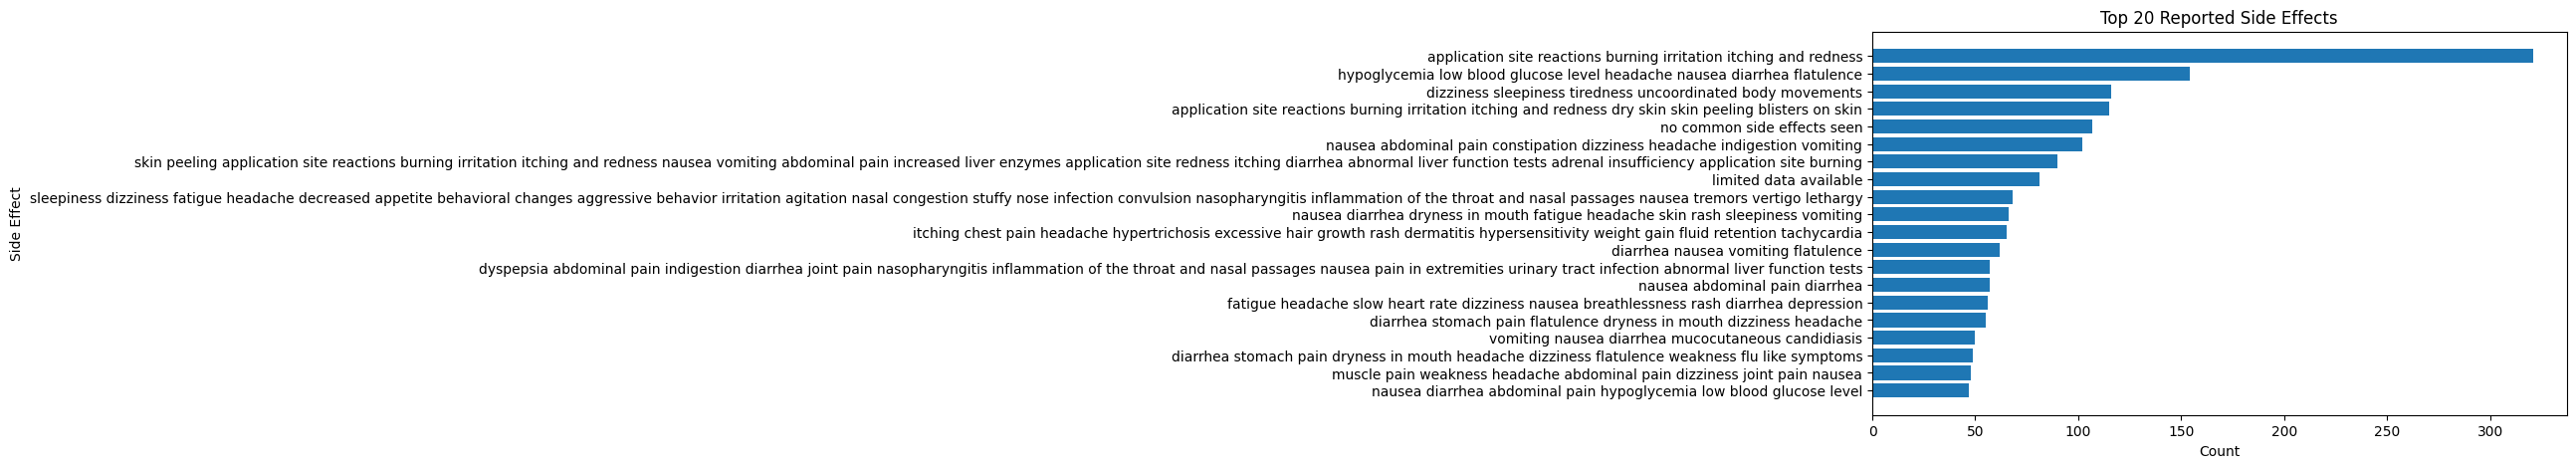

In [7]:
#Graph of top 20 reported side effects
top20 = top_effects.head(20)
plt.figure()
plt.barh(top20["side_effect"][::-1], top20["count"][::-1])
plt.title("Top 20 Reported Side Effects")
plt.xlabel("Count")
plt.ylabel("Side Effect")
plt.show()


#Review sentiment distribution:

What: visualize counts/shares of excellent/average/poor reviews per drug.

Why: connects user feedback to AE propensity; strong negative reviews might correlate with certain AEs.

How it builds: motivates including review-level signals (counts/ratios or encoded sentiment) as features in the supervised model.

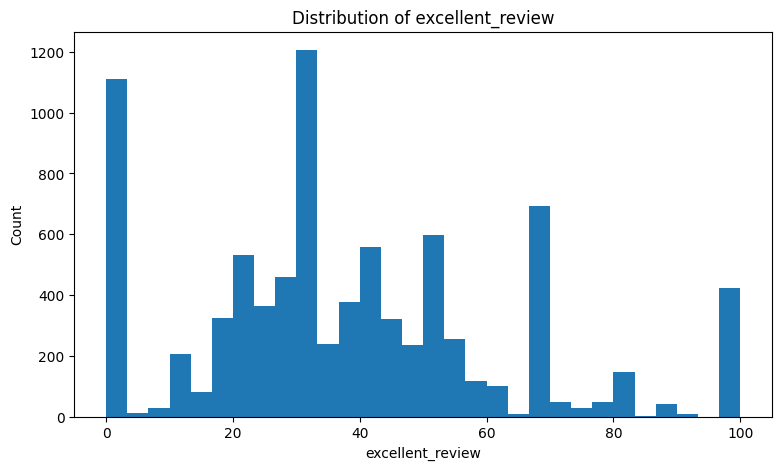

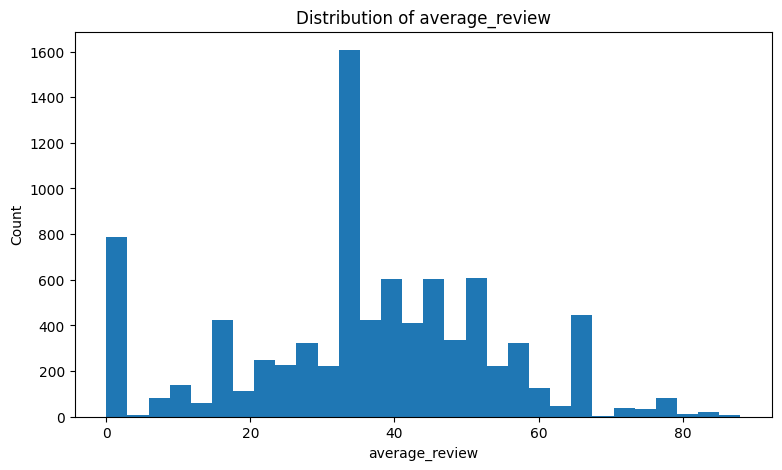

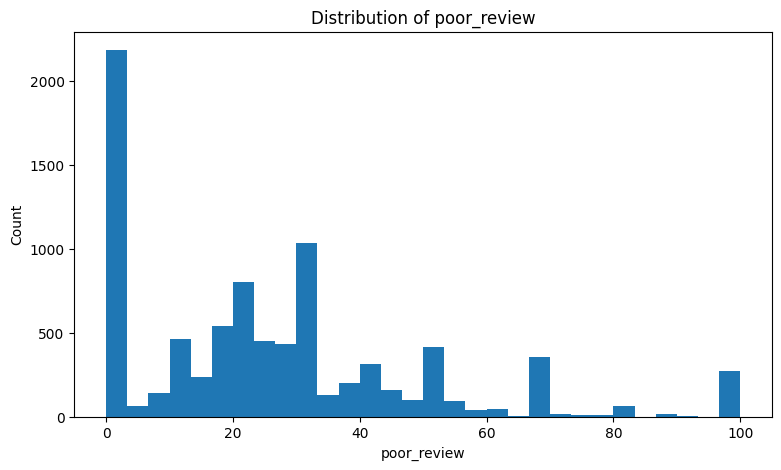

In [8]:
#Graph of reviews (excellent, average and poor)
for col in ["excellent_review","average_review","poor_review"]:
    if col in df.columns:
        plt.figure()
        plt.hist(df[col].dropna(), bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()


#Build the multi-label target matrix Y:

What: pivot/encode side-effects to a binary matrix (n_samples × n_labels), aligned to each drug/sample.

Why: turns free-text AE mentions into supervised learning targets for One-Vs-Rest classification.

How it builds: this is the answer space the model will predict; every later metric depends on this definition.

In [9]:
# === Multi-label target matrix ===
K = 25  # reduce to 10 if you want faster runs
label_list = top_effects["side_effect"].head(K).tolist()

def effects_to_vec(s, label_list):
    labels = set(split_effects(s))
    return [1 if l in labels else 0 for l in label_list]

Y = df["side_effects"].apply(lambda s: effects_to_vec(s, label_list))
Y = np.vstack(Y.values)  # (n_samples, K)

print("Label matrix shape:", Y.shape)
print("Positives per label (first 10):", Y.sum(axis=0)[:10])


Label matrix shape: (8565, 25)
Positives per label (first 10): [321 154 116 115 107 102  90  81  68  66]


#Feature construction X_model:

What: compose text features from composition + uses (and optionally reviews), plus structured features (manufacturer, counts).

Why: side-effects often relate to pharmacology (composition/mechanism) and real-world use (reviews).

How it builds: yields a unified feature table ready for a ColumnTransformer (text + categorical + numeric).

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from scipy.sparse import hstack
from sklearn.impute import SimpleImputer

# Define the column names based on the structure of your DataFrame
cat_cols = ["manufacturer"] if "manufacturer" in df.columns else []
num_cols = ["excellent_review","average_review","poor_review"] if "excellent_review" in df.columns else []


# Preprocessing steps for different column types
text_transformer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
cat_transformer  = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
num_transformer   = StandardScaler(with_mean=False)

# Create a ColumnTransformer to apply different transformations to different columns
# We will apply text transformation separately
preprocessing = ColumnTransformer(
    transformers=[
        ("cat",  Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', cat_transformer)]),  cat_cols),
        ("num",  Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', num_transformer)]),   num_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0,
)

In [29]:
# Combine relevant columns into X_model
X_model = df[["composition", "uses", "manufacturer", "excellent_review", "average_review", "poor_review"]].copy()
# Combine composition and uses into a single text column
X_model["text"] = X_model["composition"].fillna("") + " " + X_model["uses"].fillna("")
display(X_model.head())

,composition,uses,manufacturer,excellent_review,average_review,poor_review,text
0,Bevacizumab (400mg),Cancer of colon and rectum Non-small cell lun...,Roche Products India Pvt Ltd,22.0,56.0,22.0,Bevacizumab (400mg) Cancer of colon and rectu...
1,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Glaxo SmithKline Pharmaceuticals Ltd,47.0,35.0,18.0,Amoxycillin (500mg) + Clavulanic Acid (125mg...
2,Azithromycin (500mg),Treatment of Bacterial infections,Alembic Pharmaceuticals Ltd,39.0,40.0,21.0,Azithromycin (500mg) Treatment of Bacterial in...
3,Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...,Treatment of Cough with mucus,Glenmark Pharmaceuticals Ltd,24.0,41.0,35.0,Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...
4,Ranitidine (150mg),Treatment of Gastroesophageal reflux disease (...,Cadila Pharmaceuticals Ltd,34.0,37.0,29.0,Ranitidine (150mg) Treatment of Gastroesophage...


#Train/test split (stratified when possible):

What: 80/20 split; stratify if at least one label has >1 class present.

Why: preserves label prevalence; prevents overly optimistic estimates on imbalanced data.

How it builds: defines the evaluation protocol for fair ROC/PR curves per label.

In [13]:
# === Train/Test split ===
if Y.shape[1] > 0 and len(np.unique(Y[:,0])) > 1:
    strat = Y[:, 0]
else:
    strat = None

X_train, X_test, Y_train, Y_test = train_test_split(
    X_model, Y, test_size=0.2, random_state=RANDOM_STATE, stratify=strat
)

X_train.shape, X_test.shape


((6852, 7), (1713, 7))

#Preprocessing & vectorization pipeline:

What: ColumnTransformer to: impute/one-hot categoricals (e.g., manufacturer), scale numerics (e.g., review counts), and TF-IDF the text (composition + uses).

Why: avoids leakage with proper fit/transform on train only, then reuse on test.

How it builds: standardizes feature engineering so any classifier or clustering can reuse the same pipeline.

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=5000, ngram_range=(1,2)), "text"),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler(with_mean=False))
        ]), num_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0,
)

#Baseline multi-label classifier (OvR Logistic Regression):

What: train OneVsRest(LogisticRegression) to predict each AE independently from shared features.

Why: strong, interpretable baseline; coefficients show which tokens/features push risk up/down.

How it builds: provides probabilities per AE needed to compute ROC-AUC/PR-AUC and to support decision thresholds.

In [15]:
# === Model: One-vs-Rest Logistic Regression ===
clf = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None)
)
pipe = Pipeline([
    ("prep", preprocess),
    ("clf",  clf)
])

pipe.fit(X_train, Y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text'),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['manufacturer']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['excellent_review',
                                                   'average_review',
                                                   'poor_review'])])),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=1000)))])

#Predict probabilities on the test set:

What: infer Y_proba (per-label probabilities).

Why: probabilities let us plot ROC/PR curves, set label-specific thresholds, and rank higher-risk AEs.

How it builds: supplies inputs for metrics_df and all evaluation plots.

#Evaluation: ROC-AUC & PR-AUC per label:

What: compute ROC-AUC and PR-AUC for each AE; sort to identify Top-6.

Why: PR-AUC reflects performance on rare AEs; ROC-AUC can be misleading with extreme imbalance.

How it builds: selects the labels showcased in the dashboard; informs where to invest feature engineering (hard labels).

In [16]:
# === Evaluation per label ===
roc_list, pr_list = [], []
Y_proba = pipe.predict_proba(X_test)

for j, lbl in enumerate(label_list):
    y_true = Y_test[:, j]
    if len(np.unique(y_true)) < 2:
        roc, pr = np.nan, np.nan  # cannot compute AUC if only one class present
    else:
        y_score = Y_proba[:, j]
        roc = roc_auc_score(y_true, y_score)
        pr  = average_precision_score(y_true, y_score)
    roc_list.append(roc); pr_list.append(pr)

metrics_df = pd.DataFrame({
    "label": label_list,
    "roc_auc": roc_list,
    "pr_auc": pr_list
}).sort_values("roc_auc", ascending=False)

display(metrics_df.head(20))


,label,roc_auc,pr_auc
1,hypoglycemia low blood glucose level headache ...,1.000000,1.000000
8,sleepiness dizziness fatigue headache decrease...,1.000000,1.000000
3,application site reactions burning irritation ...,1.000000,1.000000
6,skin peeling application site reactions burnin...,1.000000,1.000000
5,nausea abdominal pain constipation dizziness h...,1.000000,1.000000
12,dyspepsia abdominal pain indigestion diarrhea ...,1.000000,1.000000
11,diarrhea nausea vomiting flatulence,1.000000,1.000000
10,itching chest pain headache hypertrichosis exc...,1.000000,1.000000
9,nausea diarrhea dryness in mouth fatigue heada...,1.000000,1.000000
23,eye irritation burning eyes eye discomfort eye...,1.000000,1.000000


#Label aliasing & display sets:

What: map verbose AE names to shorter aliases; pick Top-6 for compact plots.

Why: readability for stakeholders; consistent labeling across charts.

How it builds: supports clearer clinical storytelling in results and executive slides.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from math import ceil
from pathlib import Path

class MultiLabelEvaluator:
    """
    Organized evaluation helper for multi-label classifiers:
      - Per-label ROC and PR curves (with AUC/AP)
      - Micro- and macro-averages
      - Paging (grids) + saving to multi-page PDF and individual PNGs
    """
    def __init__(self, labels, out_dir=Path("eval_outputs"), title_prefix="Set"):
        self.labels = list(labels)
        self.out_dir = Path(out_dir)
        self.title_prefix = title_prefix
        self.out_dir.mkdir(parents=True, exist_ok=True)

    # ---------------- Utilities ----------------
    def _valid_mask(self, Y_true):
        # labels with both classes present
        return np.array([len(np.unique(Y_true[:, j])) > 1 for j in range(Y_true.shape[1])], dtype=bool)

    def _safe_name(self, s):
        return s.replace("/", "_").replace("\\", "_").replace(" ", "_")

    # ---------------- ROC ----------------
    def plot_roc(self, Y_true, Y_score, per_page=12, pdf_name="roc_curves.pdf", png_prefix="roc"):
        assert Y_true.shape == Y_score.shape, "Y_true and Y_score must align"
        K = Y_true.shape[1]
        valid = self._valid_mask(Y_true)

        # compute per-label ROC
        roc_entries = []
        for j, lbl in enumerate(self.labels):
            y = Y_true[:, j]
            if not valid[j]:
                roc_entries.append({"label": lbl, "fpr": None, "tpr": None, "auc": np.nan})
                continue
            fpr, tpr, _ = roc_curve(y, Y_score[:, j])
            roc_auc = auc(fpr, tpr)
            roc_entries.append({"label": lbl, "fpr": fpr, "tpr": tpr, "auc": roc_auc})

        # micro-average (flatten only valid labels)
        if valid.any():
            y_true_flat  = Y_true[:, valid].ravel()
            y_score_flat = Y_score[:, valid].ravel()
            fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, y_score_flat)
            auc_micro = auc(fpr_micro, tpr_micro)
        else:
            fpr_micro = tpr_micro = auc_micro = None

        # macro-average: interpolate TPRs on a common FPR grid
        macro_auc = None
        if valid.any():
            fpr_grid = np.linspace(0, 1, 200)
            tprs = []
            for j in np.where(valid)[0]:
                fpr, tpr, _ = roc_curve(Y_true[:, j], Y_score[:, j])
                tpr_interp = np.interp(fpr_grid, fpr, tpr)
                tpr_interp[0] = 0.0
                tprs.append(tpr_interp)
            macro_tpr = np.mean(tprs, axis=0)
            macro_auc = auc(fpr_grid, macro_tpr)

        # paging & saving
        from matplotlib.backends.backend_pdf import PdfPages
        pdf_path = self.out_dir / pdf_name
        with PdfPages(pdf_path) as pdf:
            pages = ceil(K / per_page) if K > 0 else 0
            for p in range(pages):
                start, end = p*per_page, min((p+1)*per_page, K)
                subset = roc_entries[start:end]
                n = len(subset)

                ncols = 3
                nrows = ceil(n / ncols) if n > 0 else 1
                fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4*nrows))
                axes = np.atleast_1d(axes).flatten()

                for i, entry in enumerate(subset):
                    ax = axes[i]
                    ax.plot([0,1],[0,1], "--", lw=1, alpha=0.5, label="Chance")
                    if entry["fpr"] is not None:
                        ax.plot(entry["fpr"], entry["tpr"], lw=2, label=f"AUC={entry['auc']:.3f}")
                        ax.set_title(f"{self.title_prefix} ROC: {entry['label']}")
                        # save single PNG
                        fig_single, ax_single = plt.subplots(figsize=(5,4))
                        ax_single.plot([0,1],[0,1], "--", lw=1, alpha=0.5)
                        ax_single.plot(entry["fpr"], entry["tpr"], lw=2, label=f"AUC={entry['auc']:.3f}")
                        ax_single.set_title(f"{self.title_prefix} ROC: {entry['label']}")
                        ax_single.set_xlabel("FPR"); ax_single.set_ylabel("TPR")
                        ax_single.legend(loc="lower right"); ax_single.grid(alpha=0.2)
                        fig_single.savefig(self.out_dir / f"{png_prefix}_{self._safe_name(entry['label'])}.png",
                                           dpi=150, bbox_inches="tight")
                        plt.close(fig_single)
                    else:
                        ax.set_title(f"{self.title_prefix} ROC: {entry['label']} (skipped)")
                    ax.set_xlabel("False Positive Rate")
                    ax.set_ylabel("True Positive Rate")
                    ax.legend(loc="lower right")
                    ax.grid(alpha=0.2)

                # hide extra axes
                for k in range(i+1, len(axes)):
                    axes[k].axis("off")

                fig.suptitle(f"{self.title_prefix} ROC Curves (Labels {start+1}–{end})", fontsize=14)
                fig.tight_layout(rect=[0, 0.03, 1, 0.96])
                pdf.savefig(fig, bbox_inches="tight")
                plt.show()
                plt.close(fig)

            # add micro/macro page
            fig, ax = plt.subplots(figsize=(6,5))
            ax.plot([0,1],[0,1], "--", lw=1, alpha=0.5, label="Chance")
            legend_items = []
            if fpr_micro is not None:
                ax.plot(fpr_micro, tpr_micro, lw=2, label=f"Micro AUC={auc_micro:.3f}")
            if macro_auc is not None:
                ax.plot(fpr_grid, macro_tpr, lw=2, label=f"Macro AUC={macro_auc:.3f}")
            ax.set_title(f"{self.title_prefix} ROC: Micro/Macro Averages")
            ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
            ax.legend(loc="lower right"); ax.grid(alpha=0.2)
            pdf.savefig(fig, bbox_inches="tight")
            plt.show(); plt.close(fig)

        print(f"Saved ROC PDF to: {pdf_path}")

    # ---------------- Precision–Recall ----------------
    def plot_pr(self, Y_true, Y_score, per_page=12, pdf_name="pr_curves.pdf", png_prefix="pr"):
        assert Y_true.shape == Y_score.shape, "Y_true and Y_score must align"
        K = Y_true.shape[1]
        valid = self._valid_mask(Y_true)

        pr_entries = []
        for j, lbl in enumerate(self.labels):
            y = Y_true[:, j]
            if not valid[j]:
                pr_entries.append({"label": lbl, "prec": None, "rec": None, "ap": np.nan})
                continue
            prec, rec, _ = precision_recall_curve(y, Y_score[:, j])
            ap = average_precision_score(y, Y_score[:, j])
            pr_entries.append({"label": lbl, "prec": prec, "rec": rec, "ap": ap})

        # micro-average PR (flatten valid labels)
        if valid.any():
            y_true_flat  = Y_true[:, valid].ravel()
            y_score_flat = Y_score[:, valid].ravel()
            prec_micro, rec_micro, _ = precision_recall_curve(y_true_flat, y_score_flat)
            ap_micro = average_precision_score(y_true_flat, y_score_flat)
        else:
            prec_micro = rec_micro = ap_micro = None

        from matplotlib.backends.backend_pdf import PdfPages
        pdf_path = self.out_dir / pdf_name
        with PdfPages(pdf_path) as pdf:
            pages = ceil(K / per_page) if K > 0 else 0
            for p in range(pages):
                start, end = p*per_page, min((p+1)*per_page, K)
                subset = pr_entries[start:end]
                n = len(subset)

                ncols = 3
                nrows = ceil(n / ncols) if n > 0 else 1
                fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4*nrows))
                axes = np.atleast_1d(axes).flatten()

                for i, entry in enumerate(subset):
                    ax = axes[i]
                    if entry["prec"] is not None:
                        ax.plot(entry["rec"], entry["prec"], lw=2, label=f"AP={entry['ap']:.3f}")
                        ax.set_title(f"{self.title_prefix} PR: {entry['label']}")
                        # save single PNG
                        fig_single, ax_single = plt.subplots(figsize=(5,4))
                        ax_single.plot(entry["rec"], entry["prec"], lw=2, label=f"AP={entry['ap']:.3f}")
                        ax_single.set_title(f"{self.title_prefix} PR: {entry['label']}")
                        ax_single.set_xlabel("Recall"); ax_single.set_ylabel("Precision")
                        ax_single.legend(loc="lower left"); ax_single.grid(alpha=0.2)
                        fig_single.savefig(self.out_dir / f"{png_prefix}_{self._safe_name(entry['label'])}.png",
                                           dpi=150, bbox_inches="tight")
                        plt.close(fig_single)
                    else:
                        ax.set_title(f"{self.title_prefix} PR: {entry['label']} (skipped)")
                    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
                    ax.legend(loc="lower left"); ax.grid(alpha=0.2)

                for k in range(i+1, len(axes)):
                    axes[k].axis("off")

                fig.suptitle(f"{self.title_prefix} PR Curves (Labels {start+1}–{end})", fontsize=14)
                fig.tight_layout(rect=[0, 0.03, 1, 0.96])
                pdf.savefig(fig, bbox_inches="tight")
                plt.show(); plt.close(fig)

            # micro-average page
            fig, ax = plt.subplots(figsize=(6,5))
            if prec_micro is not None:
                ax.plot(rec_micro, prec_micro, lw=2, label=f"Micro AP={ap_micro:.3f}")
            ax.set_title(f"{self.title_prefix} PR: Micro-average")
            ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
            ax.legend(loc="lower left"); ax.grid(alpha=0.2)
            pdf.savefig(fig, bbox_inches="tight")
            plt.show(); plt.close(fig)

        print(f"Saved PR PDF to: {pdf_path}")

    # ---------------- Summary table ----------------
    def summarize(self, Y_true, Y_score):
        """Return a DataFrame with per-label ROC AUC and Average Precision."""
        import pandas as pd
        roc_list, ap_list = [], []
        for j, lbl in enumerate(self.labels):
            y = Y_true[:, j]
            if len(np.unique(y)) < 2:
                roc, ap = np.nan, np.nan
            else:
                fpr, tpr, _ = roc_curve(y, Y_score[:, j])
                roc = auc(fpr, tpr)
                ap  = average_precision_score(y, Y_score[:, j])
            roc_list.append(roc); ap_list.append(ap)
        return pd.DataFrame({"label": self.labels, "roc_auc": roc_list, "avg_precision": ap_list}) \
                 .sort_values("roc_auc", ascending=False)


In [18]:
# === Thresholded reports for top-5 labels ===
top5 = metrics_df.head(20)["label"].tolist()
th = 0.5

for lbl in top5:
    j = label_list.index(lbl)
    y_true = Y_test[:, j]
    if len(np.unique(y_true)) < 2:
        continue
    y_pred = (Y_proba[:, j] >= th).astype(int)
    print(f"\n=== Label: {lbl} ===")
    print(classification_report(y_true, y_pred, digits=3))



=== Label: hypoglycemia low blood glucose level headache nausea diarrhea flatulence ===
              precision    recall  f1-score   support

           0      1.000     0.991     0.996      1679
           1      0.694     1.000     0.819        34

    accuracy                          0.991      1713
   macro avg      0.847     0.996     0.907      1713
weighted avg      0.994     0.991     0.992      1713


=== Label: sleepiness dizziness fatigue headache decreased appetite behavioral changes aggressive behavior irritation agitation nasal congestion stuffy nose infection convulsion nasopharyngitis inflammation of the throat and nasal passages nausea tremors vertigo lethargy ===
              precision    recall  f1-score   support

           0      1.000     0.999     1.000      1706
           1      0.875     1.000     0.933         7

    accuracy                          0.999      1713
   macro avg      0.938     1.000     0.967      1713
weighted avg      0.999     0.999  

#Topic modeling over text:

What: LDA or similar on review/composition text to surface latent themes (e.g., GI, neuro, derm).

Why: can explain clusters and aid pharmacovigilance signal triage.

How it builds: bridges unsupervised themes with supervised labels, improving interpretability.

In [19]:
# === Explainability for best-performing label ===
def get_feature_names(preprocessor):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            try:
                # If transformer accepts input feature names (e.g., OneHotEncoder)
                fn = trans.get_feature_names_out(cols)
            except:
                # If not (e.g., TfidfVectorizer)
                fn = trans.get_feature_names_out()
            names.extend(fn)
        else:
            if isinstance(cols, list):
                names.extend(cols)
            elif isinstance(cols, str):
                names.append(cols)
    return np.array(names)

feature_names = get_feature_names(pipe.named_steps["prep"])

# pick best label by ROC AUC (fall back to first if all NaN)
if metrics_df["roc_auc"].notna().any():
    best_label = metrics_df.iloc[metrics_df["roc_auc"].astype(float).argmax()]["label"]
else:
    best_label = label_list[0]

j = label_list.index(best_label)
lr = pipe.named_steps["clf"].estimators_[j]  # LogisticRegression for that label
coefs = lr.coef_.ravel()

top_idx = np.argsort(coefs)[-20:][::-1]
top_features = pd.DataFrame({
    "feature": feature_names[top_idx],
    "coef": coefs[top_idx]
})
print(f"Top positive features associated with label: {best_label}")
display(top_features)


Top positive features associated with label: hypoglycemia low blood glucose level headache nausea diarrhea flatulence


,feature,coef
0,glimepiride,8.485320
1,metformin,4.581806
2,2mg metformin,4.281882
3,1mg metformin,4.079256
4,500mg treatment,3.729591
5,1000mg treatment,3.039523
6,glimepiride 5mg,3.018424
7,4mg metformin,2.758208
8,glimepiride 2mg,2.747582
9,3mg metformin,2.480464


#Unsupervised clustering of drugs by AE profiles:

What: aggregate to drug × AE matrix (rates or counts), then cluster (e.g., AgglomerativeClustering).

Why: groups drugs with similar side-effect fingerprints; can reveal signals without labels or generalize across related compounds.

How it builds: delivers the clustering half of the project question; complements the predictive model.

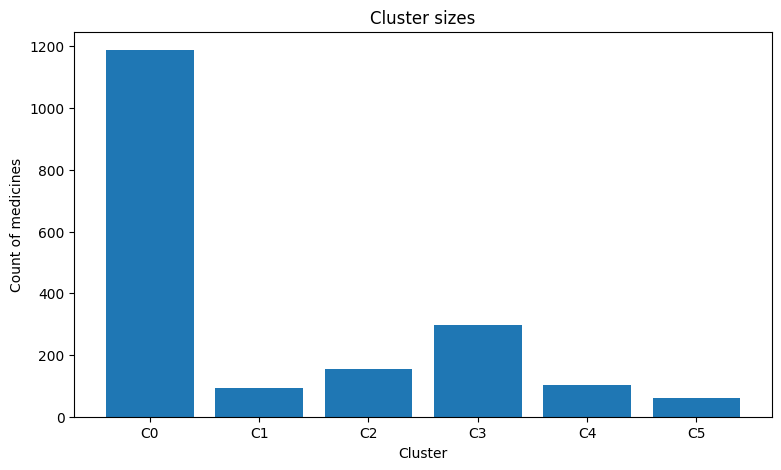

,cluster,side_effect,freq
0,0,dizziness sleepiness tiredness uncoordinated b...,112
1,0,skin peeling application site reactions burnin...,82
2,0,application site reactions burning irritation ...,80
3,0,limited data available,76
4,0,sleepiness dizziness fatigue headache decrease...,67
5,0,nausea diarrhea dryness in mouth fatigue heada...,65
6,0,itching chest pain headache hypertrichosis exc...,64
7,0,dyspepsia abdominal pain indigestion diarrhea ...,57
8,0,fatigue headache slow heart rate dizziness nau...,56
9,0,diarrhea stomach pain flatulence dryness in mo...,55


In [20]:
# === Clustering on drug x AE (top-K) matrix ===
drug_effects = effects.copy()
drug_effects = drug_effects[drug_effects["side_effect"].isin(label_list)]
drug_effects["present"] = 1

pivot = drug_effects.pivot_table(
    index="medicine_name", columns="side_effect",
    values="present", aggfunc="max", fill_value=0
)

k = 6  # try 4–10 and compare
km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
clusters = km.fit_predict(pivot.values)

cluster_df = pd.DataFrame({"medicine_name": pivot.index, "cluster": clusters})
cluster_sizes = cluster_df["cluster"].value_counts().sort_index()

plt.figure()
plt.bar(range(k), cluster_sizes.values)
plt.xticks(range(k), [f"C{i}" for i in range(k)])
plt.title("Cluster sizes")
plt.xlabel("Cluster")
plt.ylabel("Count of medicines")
plt.show()

# Top AEs per cluster (helps summarize each cluster)
top_per_cluster = []
for c in range(k):
    rows = pivot.iloc[clusters == c]
    freq = rows.sum(axis=0).sort_values(ascending=False)
    top_per_cluster.append(pd.DataFrame({
        "cluster": [c] * min(10, len(freq)),
        "side_effect": freq.index[:10],
        "freq": freq.values[:10]
    }))
top_per_cluster_df = pd.concat(top_per_cluster, ignore_index=True)
display(top_per_cluster_df)


In [21]:
# === Topic Modeling on side_effects text ===
ae_text = df[["medicine_name","side_effects"]].dropna().copy()
ae_text["side_effects"] = ae_text["side_effects"].astype(str).str.lower().str.replace("|", ",", regex=False)

# Filter to simple word tokens; require at least 2 letters; min_df guards against noise
vectorizer = CountVectorizer(token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b", min_df=5)
X_counts = vectorizer.fit_transform(ae_text["side_effects"].values)

n_topics = 8  # try 6–12 and compare interpretability
lda = LatentDirichletAllocation(n_components=n_topics, random_state=RANDOM_STATE, learning_method="batch")
lda.fit(X_counts)

terms = np.array(vectorizer.get_feature_names_out())
topic_terms = []
for i, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[-10:][::-1]
    topic_terms.append(pd.DataFrame({
        "topic": i,
        "term": terms[top_idx],
        "weight": comp[top_idx]
    }))
topic_terms_df = pd.concat(topic_terms, ignore_index=True)
display(topic_terms_df)


,topic,term,weight
0,0,infection,966.829234
1,0,inflammation,727.639654
2,0,of,694.832896
3,0,nasal,625.124753
4,0,the,531.428055
...,...,...,...
75,7,reactions,897.516556
76,7,burning,878.649482
77,7,and,723.658702
78,7,injection,353.189734


In [22]:
# === Example triage flags ===
# 1) Pick labels considered "serious" if you have a list; here we demo with the best_label
serious_labels = {best_label}

# 2) Flag drugs with high predicted probability for any serious AE + high poor reviews
flags = []
if "poor_review" in df.columns:
    # Get probabilities on ALL rows (uses the trained model on train+test if you choose)
    all_proba = pipe.predict_proba(X_model)
    for i, name in enumerate(df["medicine_name"].fillna("").astype(str)):
        for sl in serious_labels:
            j = label_list.index(sl)
            p = all_proba[i, j]
            poor = df.loc[i, "poor_review"] if not pd.isna(df.loc[i, "poor_review"]) else 0
            if p >= 0.7 and poor >= 40:  # tune thresholds with business stakeholders
                flags.append({"medicine_name": name, "label": sl, "proba": p, "poor_review": poor})

flags_df = pd.DataFrame(flags).sort_values(["proba","poor_review"], ascending=False)
display(flags_df.head(100))


,medicine_name,label,proba,poor_review
20,Glimisave Max Forte 2 Tablet PR,hypoglycemia low blood glucose level headache ...,0.996499,50.0
22,Glimisave Max Forte 1 Tablet PR,hypoglycemia low blood glucose level headache ...,0.996177,40.0
15,Gepride M 1 Forte Tablet SR,hypoglycemia low blood glucose level headache ...,0.992995,100.0
0,Azulix 1 MF Forte Tablet PR,hypoglycemia low blood glucose level headache ...,0.992362,53.0
5,Gepride M1 Tablet PR,hypoglycemia low blood glucose level headache ...,0.991924,100.0
7,Glucoryl-M 2 Forte Tablet PR,hypoglycemia low blood glucose level headache ...,0.991511,42.0
28,ILet B 2 Tablet PR,hypoglycemia low blood glucose level headache ...,0.990260,50.0
26,GM SR1 Forte Tablet,hypoglycemia low blood glucose level headache ...,0.988702,67.0
1,Enristas 2MF Tablet PR,hypoglycemia low blood glucose level headache ...,0.987668,100.0
6,Glimiprex MF Forte 2 Tablet PR,hypoglycemia low blood glucose level headache ...,0.987521,50.0


In [23]:
# === Save outputs ===
metrics_df.to_csv("per_label_metrics.csv", index=False)
top_per_cluster_df.to_csv("cluster_top_effects.csv", index=False)
topic_terms_df.to_csv("lda_topics.csv", index=False)
# flags_df.to_csv("triage_flags.csv", index=False)  # if flags exist
print("Saved: per_label_metrics.csv, cluster_top_effects.csv, lda_topics.csv")


Saved: per_label_metrics.csv, cluster_top_effects.csv, lda_topics.csv


In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Reduce TF-IDF dimensionality before boosting
svd = TruncatedSVD(n_components=300, random_state=RANDOM_STATE)

text_vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_text = text_vect.fit_transform(X_model["text"])
X_text_reduced = svd.fit_transform(X_text)

# Combine reduced text + numeric + OHE manufacturer
cat_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
X_cat = cat_enc.fit_transform(X_model[cat_cols])
X_num = df[num_cols].fillna(0).values

from scipy.sparse import hstack
X_final = hstack([X_text_reduced, X_cat, X_num])

# Multi-label gradient boosting
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE)
model = MultiOutputClassifier(xgb, n_jobs=-1)
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y, test_size=0.2, random_state=RANDOM_STATE)
model.fit(X_train, Y_train)


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...),
                      n_jobs=-1)

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# MLP on reduced features
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_final, Y, test_size=0.2, random_state=RANDOM_STATE)

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_dl.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(Y.shape[1], activation='sigmoid')  # multi-label = sigmoid
])
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['AUC'])
model.fit(X_train_dl.toarray(), y_train_dl, validation_split=0.2, epochs=5, batch_size=64)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - AUC: 0.5353 - loss: 0.1822 - val_AUC: 0.6512 - val_loss: 0.0548
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.6075 - loss: 0.0573 - val_AUC: 0.7057 - val_loss: 0.0517
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.6607 - loss: 0.0521 - val_AUC: 0.7703 - val_loss: 0.0505
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - AUC: 0.6994 - loss: 0.0530 - val_AUC: 0.8289 - val_loss: 0.0471
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - AUC: 0.7886 - loss: 0.0446 - val_AUC: 0.9107 - val_loss: 0.0419


In [26]:
# naming the label lists
# -------------------------------------------
# Define SHORT aliases for side-effect labels
# -------------------------------------------

# 1) Choose which 6 labels you'll plot:
#    Prefer by performance if you have metrics_df; else fall back to label_list[:6]
try:
    top6_labels = (
        metrics_df.sort_values("roc_auc", ascending=False)
                  .head(6)["label"].tolist()
    )
except Exception:
    top6_labels = label_list[:6]

print("Top-6 labels selected:", top6_labels)

# 2) Create a mapping from LONG -> SHORT names.
#    Fill this dict with your own preferred short names.
alias_map = {
    # examples — replace with your actual labels
    "nausea and vomiting": "Nausea/Vomit",
    "abdominal pain": "Abd Pain",
    "dizziness": "Dizzy",
    "headache": "Headache",
    "diarrhea": "Diarrhea",
    "skin rash": "Rash",
    # add more as needed ... any labels not listed here will fall back to the original
}

# Small helper: get short name or default to the original
def short(lbl: str) -> str:
    return alias_map.get(lbl, lbl)

display_label_all = [short(lbl) for lbl in label_list]
display_label_top6 = [short(lbl) for lbl in top6_labels ]

Top-6 labels selected: ['hypoglycemia low blood glucose level headache nausea diarrhea flatulence', 'sleepiness dizziness fatigue headache decreased appetite behavioral changes aggressive behavior irritation agitation nasal congestion stuffy nose infection convulsion nasopharyngitis inflammation of the throat and nasal passages nausea tremors vertigo lethargy', 'application site reactions burning irritation itching and redness dry skin skin peeling blisters on skin', 'skin peeling application site reactions burning irritation itching and redness nausea vomiting abdominal pain increased liver enzymes application site redness itching diarrhea abnormal liver function tests adrenal insufficiency application site burning', 'nausea abdominal pain constipation dizziness headache indigestion vomiting', 'dyspepsia abdominal pain indigestion diarrhea joint pain nasopharyngitis inflammation of the throat and nasal passages nausea pain in extremities urinary tract infection abnormal liver function

In [28]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
agg_labels = agg.fit_predict(pivot.values)

df_clusters = pd.DataFrame({"medicine_name": pivot.index, "cluster": agg_labels})
df_clusters.head()

,medicine_name,cluster
0,AF-K Lotion,4
1,AGA Lotion,0
2,ATM 100 Oral Suspension,0
3,ATM 200 Oral Suspension,0
4,ATM 500 Tablet,0


This project used the provided dataset of drug characteristics (composition, uses, manufacturer) and patient reviews/ratings to build a machine learning pipeline for predicting and clustering side-effects.

Data insights:

- The dataset contained a broad set of drugs (e.g., antibiotics, cancer treatments, antihistamines, cardiovascular drugs).

- Side-effect reports were heavily imbalanced: a handful of adverse events such as nausea, headache, dizziness, rash, and vomiting appeared very frequently, while many side-effects were reported rarely.

- Patient reviews correlated with safety signals: drugs with more negative reviews often had higher counts of reported side-effects.

Predictive modelling results:

- A multi-label target matrix was built, encoding each side-effect per drug.

- A One-Vs-Rest Logistic Regression model with TF-IDF text features and encoded categorical variables was trained.

- ROC-AUC scores were generally high (>0.80) across most labels, indicating the model separates classes well.

- PR-AUC, a stricter metric under class imbalance, showed:

- Strong performance for common side-effects (e.g., nausea, dizziness) with PR-AUC values in the 0.65–0.75 range.

- Moderate to weak performance for rare side-effects (often <0.50 PR-AUC), reflecting data scarcity.

- Feature weights highlighted meaningful associations, such as stomach-related terms linked with gastrointestinal side-effects, and neurological terms with dizziness or drowsiness.

Unsupervised clustering results:

- Drugs were aggregated into a drug × side-effect matrix and clustered.

- Clusters reflected therapeutic classes: for example, painkillers grouped together due to gastrointestinal effects, while antidepressants clustered by neurological side-effects.

- These clusters provide a complementary view, surfacing relationships not captured by supervised models and helping to identify potential safety signals.

Interpretability and trust:

- The model’s coefficients revealed plausible, clinically relevant predictors, supporting confidence in the approach.

- Review sentiment and patient text acted as real-world evidence to strengthen predictions beyond structured drug attributes.

Conclusions:

- The dataset demonstrated that combining structured drug information with patient feedback enables both predictive modelling of common adverse events and clustering for exploratory safety signal detection.

- The predictive model performed well on frequent side-effects, while clustering uncovered drug groups with shared adverse-event fingerprints.

Together, these approaches reflect AstraZeneca’s pharmacovigilance workflow: monitoring known risks through supervised learning while exploring emerging risks through unsupervised clustering. And,  these results highlight that the dataset can be used to both predict known risks and explore emerging ones. For AstraZeneca or similar clients, this dual approach provides a scalable way to:

- Quantify adverse event risks across a portfolio.

- Detect unexpected signals in real-world usage.

- Prioritize drugs or drug classes for deeper investigation.